In [ ]:
# %load /Users/Jonathan/.je.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,6

import json
import re
import time

In [2]:
import sys

In [3]:
# !conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [5]:
df_train = pd.read_csv('df_train.csv',index_col=0)
df_test = pd.read_csv('df_test.csv',index_col=0)

In [6]:
df_train.shape

(3000, 26)

In [7]:
df_train['revenue'].mean()

66725851.88866667

In [8]:
df_test.shape

(4398, 23)

### Train a model

In [9]:
df_train = df_train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
df_test = df_test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [10]:
for col in df_train.columns:
    if df_train[col].nunique() == 1:
        print(col)
        #train = train.drop([col], axis=1)
        #test = test.drop([col], axis=1)

In [11]:
df_train.columns

Index(['id', 'budget', 'genres', 'original_language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'revenue', 'collection_name',
       'has_collection', 'log_budget'],
      dtype='object')

In [12]:
df_test.columns

Index(['id', 'budget', 'genres', 'original_language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'collection_name',
       'has_collection'],
      dtype='object')

In [13]:
#for col in ['original_language', 'collection_name', 'all_genres']:
for col in ['collection_name']:
    le = LabelEncoder()
    le.fit(list(df_train[col].fillna('')) + list(df_test[col].fillna('')))
    df_train[col] = le.transform(df_train[col].fillna('').astype(str))
    df_test[col] = le.transform(df_test[col].fillna('').astype(str))

In [14]:
df_train['runtime'].apply(lambda x: pd.isna(x)).sum()

2

In [15]:
cols = ['budget', 'runtime']

In [16]:
df_train[cols].head()

,budget,runtime
0,14000000,93.0
1,40000000,113.0
2,3300000,105.0
3,1200000,122.0
4,0,118.0


In [17]:
# orig
# X = df_train.drop(['id', 'revenue'], axis=1)
# y = np.log1p(df_train['revenue'])
# X_test = df_test.drop(['id'], axis=1)
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [20]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [21]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred   
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [33]:
X = df_train[cols]
y = np.log1p(df_train['revenue'])
X_test = df_test[cols]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [34]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[618]	training's rmse: 2.30674	valid_1's rmse: 2.28676


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l1=0.2, learning_rate=0.01, max_depth=5, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
       min_split_gain=0.0, n_estimators=20000, n_jobs=-1, nthread=4,
       num_leaves=30, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [35]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

Fold 0 started at Tue May 28 13:01:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[620]	training's rmse: 2.28319	valid_1's rmse: 2.31357
Fold 1 started at Tue May 28 13:01:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 2.29828	valid_1's rmse: 2.21292
Fold 2 started at Tue May 28 13:01:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[482]	training's rmse: 2.30352	valid_1's rmse: 2.22435
Fold 3 started at Tue May 28 13:01:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[576]	training's rmse: 2.29105	valid_1's rmse: 2.26366
Fold 4 started at Tue May 28 13:01:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[492]	training's rmse: 2.28915	valid_1's rmse: 2.34861
Fold 5 started at Tu

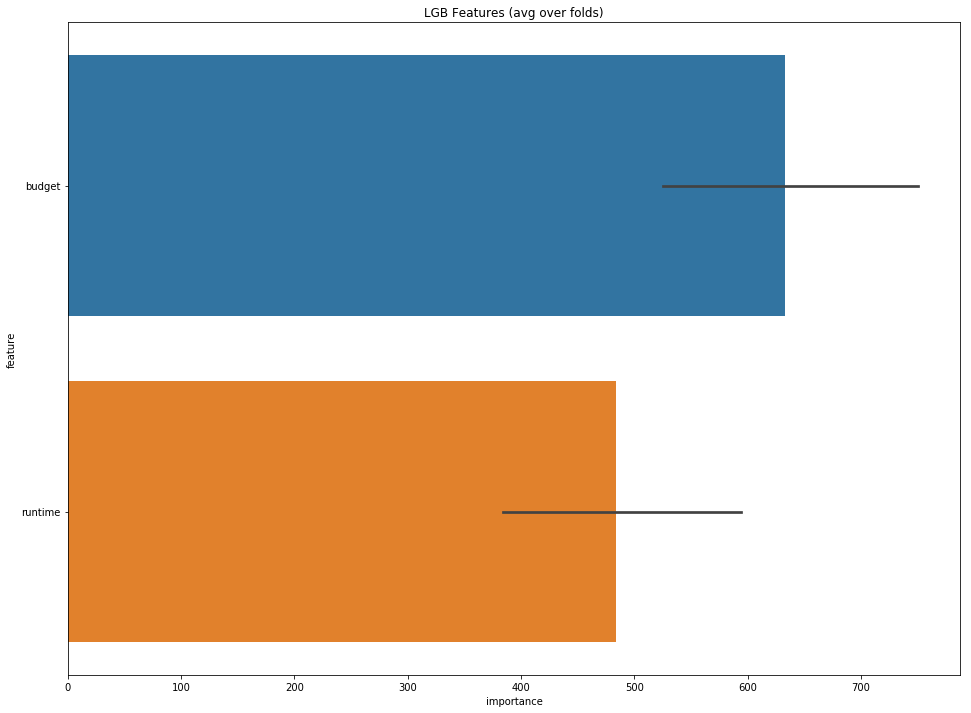

In [36]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

### Submission

In [41]:
submission = pd.read_csv('data/sample_submission.csv')
submission['revenue'] = np.expm1(prediction_lgb)
submission.to_csv('submission_lgb.csv', index=False)